In [ ]:
!pip install -q imbalanced-learn
!pip install -q smogn

In [ ]:
import os
import smogn
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
folder_path = '/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_1'
os.chdir(folder_path)

In [ ]:
df = pd.read_csv('data/homicide.csv', low_memory=False)

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.head(5)

,record id,agency code,agency name,agency type,city,state,year,month,incident,crime type,...,victim ethnicity,perpetrator sex,perpetrator age,perpetrator race,perpetrator ethnicity,relationship,weapon,victim count,perpetrator count,record source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


#preprocessing

In [ ]:
columns_to_drop = ['record id', 'agency code', 'city', 'record source', 'agency type',
                   'agency name', 'victim count', 'perpetrator count', 'crime solved',
                   'incident', 'month']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.head(5)

,state,year,crime type,victim sex,victim age,victim race,victim ethnicity,perpetrator sex,perpetrator age,perpetrator race,perpetrator ethnicity,relationship,weapon
0,Alaska,1980,Murder or Manslaughter,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object
1,Alaska,1980,Murder or Manslaughter,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation
2,Alaska,1980,Murder or Manslaughter,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown
3,Alaska,1980,Murder or Manslaughter,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation
4,Alaska,1980,Murder or Manslaughter,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown


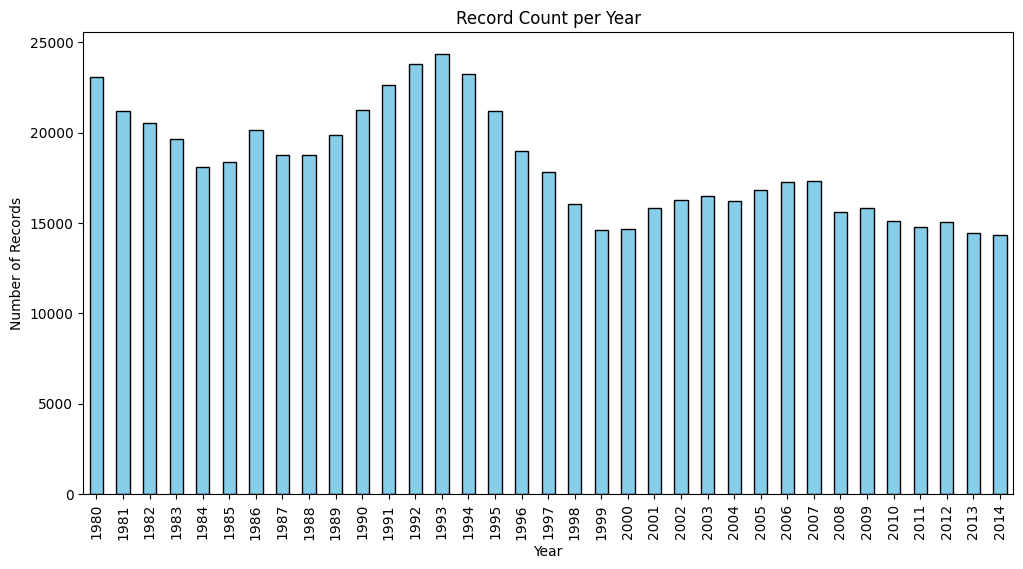

In [ ]:
# Check the distribution of records per year
year_counts = df['year'].value_counts().sort_index()

# Plot the distribution for better visualization
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Record Count per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.show()

In [ ]:
# Define the number of samples to take from each year
sample_size_per_year = 1000  # Adjust this number as needed

# Group by 'Year' and sample records from each group
sampled_df = df.groupby('year').apply(lambda x: x.sample(n=sample_size_per_year, random_state=42)).reset_index(drop=True)
sampled_df.head()

<ipython-input-10-af5bd29c4f80>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('year').apply(lambda x: x.sample(n=sample_size_per_year, random_state=42)).reset_index(drop=True)


,state,year,crime type,victim sex,victim age,victim race,victim ethnicity,perpetrator sex,perpetrator age,perpetrator race,perpetrator ethnicity,relationship,weapon
0,Louisiana,1980,Murder or Manslaughter,Male,32,White,Not Hispanic,Unknown,0,Unknown,Unknown,Unknown,Handgun
1,California,1980,Murder or Manslaughter,Male,20,White,Unknown,Unknown,0,Unknown,Unknown,Unknown,Handgun
2,Vermont,1980,Murder or Manslaughter,Male,36,White,Unknown,Male,20,White,Not Hispanic,Acquaintance,Blunt Object
3,South Carolina,1980,Murder or Manslaughter,Male,23,White,Not Hispanic,Male,40,White,Not Hispanic,Family,Drugs
4,California,1980,Murder or Manslaughter,Male,18,White,Hispanic,Unknown,0,Unknown,Unknown,Unknown,Firearm


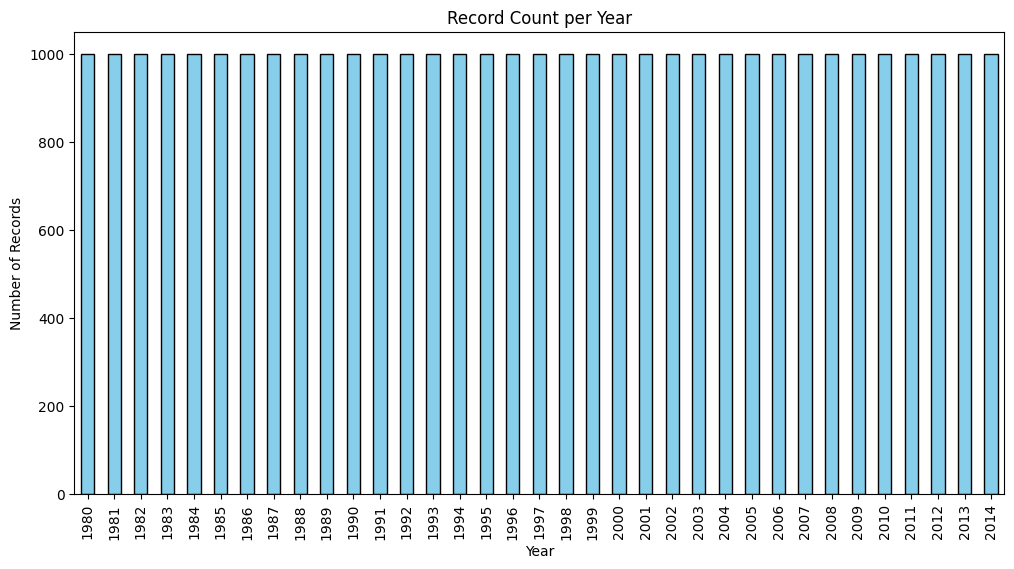

In [ ]:
# Check the distribution of records per year
year_counts = sampled_df['year'].value_counts().sort_index()
# Plot the distribution for better visualization
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Record Count per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.show()

In [ ]:
sampled_df = sampled_df.drop(columns=['perpetrator age'])

# encoding

In [ ]:
categorical_columns = [
    'state', 'crime type', 'victim sex', 'victim race', 'victim ethnicity',
    'perpetrator sex', 'perpetrator race', 'perpetrator ethnicity', 'relationship', 'weapon'
]

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

In [ ]:
df = df.drop(columns=categorical_columns).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

In [ ]:
df.head(5)

,year,victim age,perpetrator age,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,...,weapon_Firearm,weapon_Gun,weapon_Handgun,weapon_Knife,weapon_Poison,weapon_Rifle,weapon_Shotgun,weapon_Strangulation,weapon_Suffocation,weapon_Unknown
0,1980,14,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1980,43,42,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1980,30,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1980,43,42,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1980,30,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# train / test split

In [ ]:
# Split into train/test as needed
X = df.drop(columns=['victim age'])  # replace Target_Column with the actual target column name
y = df['victim age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (510763, 111) (510763,)
Test set size: (127691, 111) (127691,)


# model

In [ ]:
!pip install -q tensorflow

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))  # Dropout layer to reduce overfitting
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))  # Another dropout layer
# Output layer (one node for regression output)
model.add(tf.keras.layers.Dense(1, activation='linear'))  # Linear activation for regression

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,809 (93.00 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 1081.4242 - mae: 13.8698 - val_loss: 827.7598 - val_mae: 11.8309
Epoch 2/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 908.5088 - mae: 12.5441 - val_loss: 812.7499 - val_mae: 11.6398
Epoch 3/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 838.8857 - mae: 12.2339 - val_loss: 800.9822 - val_mae: 11.8333
Epoch 4/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 793.3549 - mae: 12.1257 - val_loss: 770.1887 - val_mae: 11.9253
Epoch 5/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 862.6069 - mae: 12.1359 - val_loss: 790.7345 - val_mae: 11.6839
Epoch 6/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 761.6634 - mae: 11.9707 - val_loss: 782.5651 - val_mae: 11.6022
Epoch 7/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 768.3553 - mae: 11.9469 - val_loss: 806.8735 - val_mae: 11.7263
Epoch 8/100
12770/12770 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 812.1193 - mae: 11.9502

#visualisation

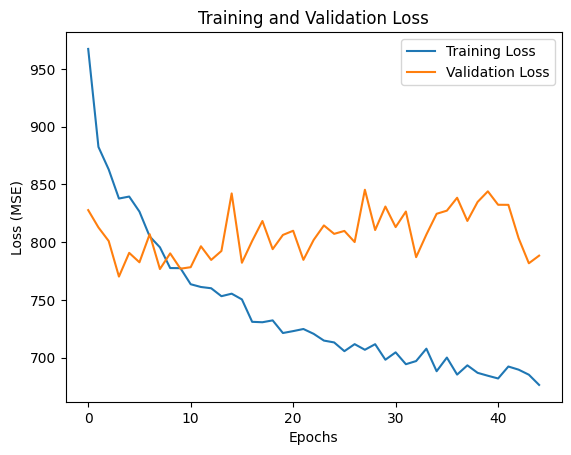

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

3991/3991 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


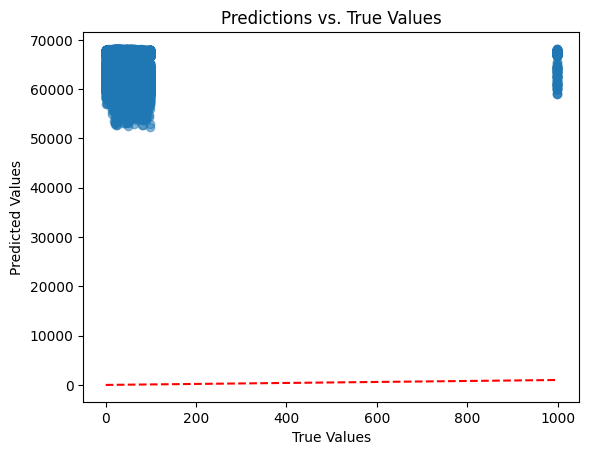

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. True Values')
plt.show()

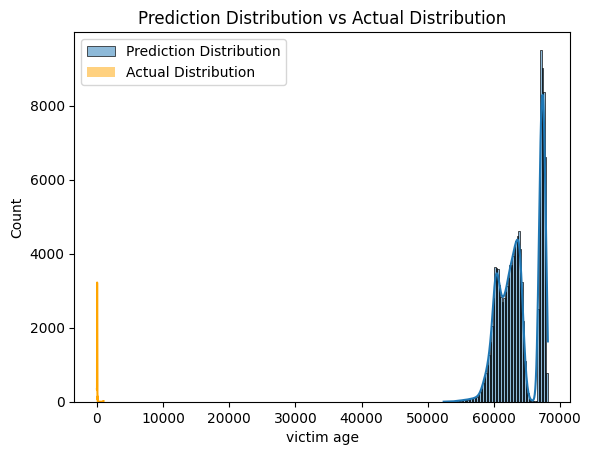

In [ ]:
sns.histplot(y_pred, kde=True, color='blue', label='Prediction Distribution')
sns.histplot(y_test, kde=True, color='orange', label='Actual Distribution')
plt.legend()
plt.title('Prediction Distribution vs Actual Distribution')
plt.show()

# error metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')
print(f'Explained Variance Score: {explained_variance}')

Mean Absolute Error (MAE): 63723.803485012155
Mean Squared Error (MSE): 4069291067.519755
Root Mean Squared Error (RMSE): 63790.99519148259
R-squared: -2269782.0
Explained Variance Score: -4778.05320154129


# imaginery numbers

In [ ]:
# Filter out encoded columns by selecting only original column names
original_column_names = [col for col in df.columns if '_' not in col]
print(original_column_names)

['year', 'victim age', 'perpetrator age']


In [ ]:
# Select only the numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Calculate correlation with the target variable (replace 'Target_Column' with your target variable name)
correlation_with_target = correlation_matrix['victim age'].sort_values(ascending=False)
display(correlation_with_target)

,victim age
victim age,1.000000
victim sex_Unknown,0.663283
victim race_Unknown,0.275662
weapon_Unknown,0.079345
relationship_Mother,0.048703
...,...
relationship_Daughter,-0.057988
relationship_Son,-0.065203
weapon_Handgun,-0.066085
victim sex_Male,-0.077936


In [ ]:
imaginary_data = pd.DataFrame({
    'top_feature_1': [80, 50, 20],    # High, medium, and low values for top_feature_1
    'top_feature_2': [100, 50, 10],   # High, medium, and low values for top_feature_2
    'top_feature_3': [5, 3, 1],       # High, medium, and low values for top_feature_3
    # Fill in the remaining columns with mean values or zeros if they are not critical
})

In [ ]:
# Fill in other columns with mean values if they are not critical
for col in X.columns:
    if col not in imaginary_data.columns:
        imaginary_data[col] = X[col].mean()

# Standardize the imaginary data if your model was trained on scaled data
imaginary_data_scaled = scaler.transform(imaginary_data)

In [ ]:
imaginary_predictions = model.predict(imaginary_data_scaled)

# Display the predictions
for i, prediction in enumerate(imaginary_predictions):
    print(f"Imaginary Data Point {i + 1} - Predicted Value: {prediction[0]}")

In [ ]:
plt.scatter(imaginary_data['top_feature_1'], imaginary_predictions, color='blue', label='Predicted Values')
plt.xlabel('Top Feature 1 (Emphasized Feature)')
plt.ylabel('Predicted Target Value')
plt.title('Predictions for Imaginary Data vs. Top Feature 1')
plt.legend()
plt.show()